In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import pickle
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [29]:
df = pd.read_csv('../datasets/Flights_2021/final_dataset-add.csv')
df.shape

(538040, 37)

In [30]:
arr_delay_0_100 = (df.shape[0] - df[(df["ArrDelayMinutes"] > 0) & (df['ArrDelayMinutes'] < 100)].shape[0])/df.shape[0]
print("ArrDelayMintues (0-100mins) captures this much data ->",  arr_delay_0_100 )
arr_delay_10_150 = (df.shape[0] - df[(df["ArrDelayMinutes"] > 10) & (df['ArrDelayMinutes'] < 150)].shape[0])/df.shape[0]
print("ArrDelayMintues (10-150mins) captures this much data  ->",  arr_delay_10_150 )
arr_delay_0_60 = (df.shape[0] - df[(df["ArrDelayMinutes"] > 0) & (df['ArrDelayMinutes'] < 60)].shape[0])/df.shape[0]
print("ArrDelayMintues (0-60mins) captures this much data  ->",  arr_delay_0_60 )


ArrDelayMintues (0-100mins) captures this much data -> 0.697212103189354
ArrDelayMintues (10-150mins) captures this much data  -> 0.8088710876514758
ArrDelayMintues (0-60mins) captures this much data  -> 0.7237844769905584


We plan to choose the range that encapsulates most of the data i.e 80% of delayed flights. 80% is relatively high but any delay below 10 min is very normal and above 150min is considered an outier.

# Remove all flights that had been on time. Now we apply regression to the delayed flights.

In [31]:
df.shape

(538040, 37)

In [32]:
df = df[df["ArrDelayMinutes"] > 0]

In [33]:
df.shape

(177894, 37)

In [34]:
df["ArrDelayMinutes"].value_counts().to_csv('buffer.csv')

In [35]:
df.columns

Index(['Unnamed: 0', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'FlightDate', 'Marketing_Airline_Network', 'Operating_Airline ',
       'OriginAirportID', 'Origin', 'DestAirportID', 'Dest', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'DepDel15', 'TaxiIn', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'DistanceGroup',
       'CombinedDateTime', 'ScaledCRSDepTime', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'rain',
       'snowfall', 'weather_code', 'surface_pressure', 'cloud_cover',
       'wind_speed_10m', 'wind_direction_10m', 'wind_direction_100m'],
      dtype='object')

In [36]:
df.drop(columns=["FlightDate","OriginAirportID","DestAirportID","CRSArrTime","Unnamed: 0","CombinedDateTime","ScaledCRSDepTime"],
        inplace=True)

In [37]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operating_Airline ', 'Origin', 'Dest',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDel15', 'TaxiIn',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'DistanceGroup',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'snowfall', 'weather_code', 'surface_pressure',
       'cloud_cover', 'wind_speed_10m', 'wind_direction_10m',
       'wind_direction_100m'],
      dtype='object')

In [38]:
df = df[df["ArrDelayMinutes"].notna()]

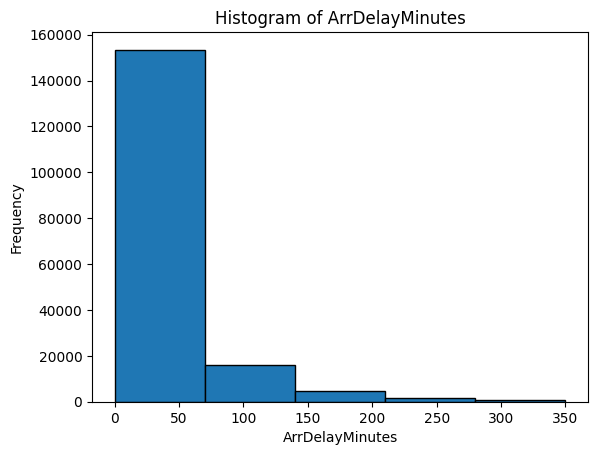

In [39]:
plt.hist(df['ArrDelayMinutes'], bins=5, edgecolor='black',range=(0, 350))  
plt.xlabel('ArrDelayMinutes')
plt.ylabel('Frequency')
plt.title('Histogram of ArrDelayMinutes')
plt.show()

In [40]:
print("Max ArrDelayMinutes = ", df['ArrDelayMinutes'].max())
print("Min ArrDelayMinutes = ", df['ArrDelayMinutes'].min())

Max ArrDelayMinutes =  2677.0
Min ArrDelayMinutes =  1.0


# Remove outlier
We don't want to ovetfit our data. So we will set the max delay to 3 hours. 

In [41]:
print(df.shape)
condition = df['ArrDelayMinutes'] < 150  # Remove the last two bins.
df = df[condition]
print(df.shape)

(177894, 30)
(170565, 30)


In [42]:
for col in df.columns:
    if df[col].isna().sum()>0:
        print(col)

In [43]:
# Replace LabelEncoder with inbuilt Encoding
airportLabel = [
    {"id": 0, "code": "BWI"},
    {"id": 1, "code": "CLT"},
    {"id": 2, "code": "DEN"},
    {"id": 3, "code": "DFW"},
    {"id": 4, "code": "DTW"},
    {"id": 5, "code": "IAH"},
    {"id": 6, "code": "LAX"},
    {"id": 7, "code": "MDW"},
    {"id": 8, "code": "ORD"},
    {"id": 9, "code": "PHL"},
    {"id": 10, "code": "PHX"},
    {"id": 11, "code": "SEA"},
    {"id": 12, "code": "SFO"},
    {"id": 13, "code": "SLC"}
]

airport_mapping = {airport['code']: airport['id'] for airport in airportLabel}


# Replace Origin and Dest columns with corresponding ids
df['Origin'] = df['Origin'].map(airport_mapping)
df['Dest'] = df['Dest'].map(airport_mapping)


# labelEncoder = LabelEncoder()
# df["Origin"] = labelEncoder.fit_transform(df["Origin"])
# df["Dest"] = labelEncoder.fit_transform(df["Dest"])



In [44]:
df['Origin']

3          3
6          3
17         3
19         3
28         3
          ..
538024     9
538026     8
538031     9
538034    10
538038    12
Name: Origin, Length: 170565, dtype: int64

In [45]:
X = df[["Origin", "Dest", "CRSDepTime", "DepDel15", 'temperature_2m', 'dew_point_2m',
       'precipitation','cloud_cover','wind_direction_100m']]
y =  np.array(df.loc[:, df.columns == "ArrDel15"]["ArrDel15"])


In [46]:
print(f"\nDataset shape: {df.shape}")
X_train, X_test, y_train, y_test = train_test_split= train_test_split(X, y, test_size=0.3, random_state=42)
print(f"X train shape: {X_train.shape} | Y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape} | Y test shape: {y_test.shape}")


Dataset shape: (170565, 30)
X train shape: (119395, 9) | Y train shape: (119395,)
X test shape: (51170, 9) | Y test shape: (51170,)


In [47]:
perf_df = pd.DataFrame(columns=["Regressors", "MSE", "RMSE", "MAE", "R2"])
def print_metrics(labels_test, model_pred, regressor_name, perf_df):
    
    mse = mean_squared_error(labels_test, model_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_test, model_pred)
    r2 = r2_score(labels_test, model_pred)
    
    print(f"MSE: {mse}", end="\n")
    print(f"RMSE: {rmse}", end="\n")
    print(f"MAE: {mae}", end="\n")
    print(f"R2 Score : {r2}", end="\n")
    
    perf_df = perf_df.append({"Regressors": regressor_name,
                                "MSE": mse, 
                                "RMSE": rmse,
                                "MAE": mae,
                                "R2": r2}, ignore_index=True)
    return perf_df

In [48]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
perf_df = print_metrics(y_test, yhat, "LinearRegression", perf_df)
del model
del yhat

MSE: 0.1770984972129486
RMSE: 0.42083072275316186
MAE: 0.3551642816909764
R2 Score : 0.29150794996480933


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [49]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_model = Lasso()

grid_search = GridSearchCV(lasso_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_lasso_model = grid_search.best_estimator_

yhat = best_lasso_model.predict(X_test)

perf_df = print_metrics(y_test, yhat, "Lasso_GridSearch", perf_df)
del grid_search
del yhat

MSE: 0.17711029112171256
RMSE: 0.4208447351716694
MAE: 0.35622703543182105
R2 Score : 0.29146076779935004


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [50]:

# Define the hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

ridge_model = Ridge()
grid_search = GridSearchCV(ridge_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_ridge_model = grid_search.best_estimator_


yhat = best_ridge_model.predict(X_test)

perf_df = print_metrics(y_test, yhat, "Ridge_GridSearch", perf_df)
del ridge_model
del yhat


MSE: 0.17709849946085424
RMSE: 0.4208307254239574
MAE: 0.3551647458661927
R2 Score : 0.2915079409719421


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [51]:
param_grid = {
    'max_depth': [None, 5, 7, 12], 
    'min_samples_split': [2, 5, 7],  
    'min_samples_leaf': [1, 2, 4]  
}

tree_model = DecisionTreeRegressor()

grid_search = GridSearchCV(tree_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_

yhat = best_tree_model.predict(X_test)

perf_df = print_metrics(y_test, yhat, "DecisionTreeRegressor_GridSearch", perf_df)
del tree_model
del yhat


MSE: 0.17622288845233636
RMSE: 0.4197890999684679
MAE: 0.3526902598696757
R2 Score : 0.2950108698404592


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [52]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
yhat = model.predict(X_test)
perf_df = print_metrics(y_test, yhat, "DecisionTreeRegressor", perf_df)
del model
del yhat

MSE: 0.34340433847957785
RMSE: 0.5860071147004768
MAE: 0.34359976548759036
R2 Score : -0.37380750028513354


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [53]:

param_grid = {
    'n_estimators': [5, 7],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 4],  
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [1, 2],  
}

gb_model = GradientBoostingRegressor()
grid_search = GridSearchCV(gb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

filename = '../models/regression-xg-boost-2.pkl' 
pickle.dump(grid_search, open(filename,'wb'))

best_gb_model = grid_search.best_estimator_
yhat = best_gb_model.predict(X_test)

perf_df = print_metrics(y_test, yhat, "GradientBoostingRegressor_GridSearch", perf_df)
del gb_model
del yhat

MSE: 0.19318690991192217
RMSE: 0.43953032877370607
MAE: 0.4233662380834911
R2 Score : 0.22714539085623575


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [54]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
yhat = model.predict(X_test)
perf_df = print_metrics(y_test, yhat, "GradientBoostingRegressor", perf_df)
del model
del yhat

MSE: 0.1748601627786832
RMSE: 0.4181628424175003
MAE: 0.3525175738723975
R2 Score : 0.30046252708970844


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [55]:
param_dist = {
    'n_estimators': [5, 6],
    'max_depth': [2,4],
    'min_samples_split': randint(2, 3),
    'min_samples_leaf': randint(1, 3)
}

rf_model = RandomForestRegressor(n_jobs=-1)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(X_train, y_train)

best_random_rf_model = random_search.best_estimator_
yhat = best_random_rf_model.predict(X_test)
perf_df = print_metrics(y_test, yhat, "RandomForestRegressor_RandomSearch", perf_df)

del rf_model
del yhat


MSE: 0.17599189943252083
RMSE: 0.419513884671915
MAE: 0.35330353593932035
R2 Score : 0.2959349538206181


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [56]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
perf_df = print_metrics(y_test, yhat, "RandomForestRegressor", perf_df)
del model
del yhat

MSE: 0.1850171034865041
RMSE: 0.43013614529181815
MAE: 0.3489407381557274
R2 Score : 0.2598291402602476


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


ExtraTreesRegressor

In [57]:
model = ExtraTreesRegressor(n_jobs=-1)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
perf_df = print_metrics(y_test, yhat, "ExtraTreesRegressor", perf_df)
del model
del yhat


MSE: 0.19211229333593902
RMSE: 0.43830616392647165
MAE: 0.34658999413718977
R2 Score : 0.23144445218595788


/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [58]:

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 75],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_
filename = '../models/regression-xg-boost-1.pkl' 
best_xgb_model.save_model(filename)

# pickle.dump(grid_search, open(filename,'wb'))

best_xgb_model = grid_search.best_estimator_
yhat = best_xgb_model.predict(X_test)

perf_df = print_metrics(y_test, yhat, "XGBRegressor_GridSearch", perf_df)
del xgb_model
del yhat


MSE: 0.17390268224766506
RMSE: 0.41701640525003936
MAE: 0.35030486063508637
R2 Score : 0.30429297938018796


/Users/biraj/yes/envs/env-ait-ml/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [10:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/var/folders/yl/xw6g0vqx5cqfc51vfpmd7m1m0000gn/T/ipykernel_56532/1708493081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf_df = perf_df.append({"Regressors": regressor_name,


In [59]:
perf_df.set_index("Regressors", inplace=True)
perf_df

,MSE,RMSE,MAE,R2
Regressors,,,,
LinearRegression,0.177098,0.420831,0.355164,0.291508
Lasso_GridSearch,0.177110,0.420845,0.356227,0.291461
Ridge_GridSearch,0.177098,0.420831,0.355165,0.291508
DecisionTreeRegressor_GridSearch,0.176223,0.419789,0.352690,0.295011
DecisionTreeRegressor,0.343404,0.586007,0.343600,-0.373808
GradientBoostingRegressor_GridSearch,0.193187,0.439530,0.423366,0.227145
GradientBoostingRegressor,0.174860,0.418163,0.352518,0.300463
RandomForestRegressor_RandomSearch,0.175992,0.419514,0.353304,0.295935
RandomForestRegressor,0.185017,0.430136,0.348941,0.259829
